# **Notebook 3: Data Cleaning**

## Objectives

* Prepare the data sets for further analysis, evaluate any missing data.
* Load and inspect the data collated during the data collection process.
* Correlation and PPS study.
* Create data cleaning pipeline and prepare data for output to model.
* Conclusion and Steps to follow.

## Tasks
* Create data input pipelines.

## Inputs

* The following files will be the intended datasets to be used:
* inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/house_prices_records.csv
* inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/inherited_houses.csv

## Outputs

* Following the data exploration and cleaning, the following outputs are expected:
* outputs/datasets/cleaned/clean_house_price_records.csv
* outputs/datasets/cleaned/clean_inherited_houses.csv
* outputs/datasets/cleaned/train_set.csv
* outputs/datasets/cleaned/test_set.csv

## Additional Comments

* This notebook was informed and guided by the steps provided in the Customer Churn Walkthrough Porject.

* We intend to explore the data using the CRISP-DM Data methodology.


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Housing-Predictive-Analytics/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Housing-Predictive-Analytics'

# Import Packages

In [4]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
from feature_engine.imputation import ArbitraryNumberImputer, CategoricalImputer
from sklearn.pipeline import Pipeline

---

# Load Data

* Load the data which was downloaded within the data collection notebook.

In [5]:
df = pd.read_csv(f"inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/house_prices_records.csv")
print(df.shape)

(1460, 24)


In [6]:
df_inherited = pd.read_csv(f"inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/inherited_houses.csv")
print(df_inherited.shape)
df_inherited

(4, 23)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
0,896,0,2,No,468.0,Rec,270.0,0,730.0,Unf,1961.0,896,TA,11622,80.0,0.0,0,6,5,882.0,140,1961,1961
1,1329,0,3,No,923.0,ALQ,406.0,0,312.0,Unf,1958.0,1329,Gd,14267,81.0,108.0,36,6,6,1329.0,393,1958,1958
2,928,701,3,No,791.0,GLQ,137.0,0,482.0,Fin,1997.0,1629,TA,13830,74.0,0.0,34,5,5,928.0,212,1997,1998
3,926,678,3,No,602.0,GLQ,324.0,0,470.0,Fin,1998.0,1604,Gd,9978,78.0,20.0,36,6,6,926.0,360,1998,1998


---

# Data Exploration
* Here would want to explore the dataset, check variable types and distribution, missing levels and what value these variables will bring in terms of the context of the first business requirement.

* First list the variables that are missing values.

In [7]:
vars_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

# Correlation and PPS Analysis

* At this point we would want to understand how the target variable "SalePrice", correlates with the features.

* The code used PPS (power predictive score) lesson materials will be used to build heatmaps for pearson and spearman correlation, including a PPS heatmap.

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

def heatmap_corr(df, threshold, figsize=(20,12), font_annot = 8):
  if len(df.columns) > 1:
    mask = np.zeros_like(df, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    mask[abs(df) < threshold] = True

    fig, axes = plt.subplots(figsize=figsize)
    sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                linewidth=0.5
                     )
    axes.set_yticklabels(df.columns, rotation = 0)
    plt.ylim(len(df.columns),0)
    plt.show()


def heatmap_pps(df, threshold, figsize=(20,12), font_annot = 8):
    if len(df.columns) > 1:

      mask = np.zeros_like(df, dtype=bool)
      mask[abs(df) < threshold] = True

      fig, ax = plt.subplots(figsize=figsize)
      ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                       mask=mask,cmap='rocket_r', annot_kws={"size": font_annot},
                       linewidth=0.05, linecolor='grey')
      
      plt.ylim(len(df.columns),0)
      plt.show()


def CalculateCorrAndPPS(df):
  df_corr_spearman = df.corr(method="spearman")
  df_corr_pearson = df.corr(method="pearson")

  print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
  

  return df_corr_pearson, df_corr_spearman


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, CorrThreshold, PPS_Threshold,
                      figsize=(20,12), font_annot=8 ):

  print("\n")
  print("* Here I can analyze how the target variable for your ML models are correlated with other variables (features and target)")
  print("* Analyze multi colinearity, that is, how the features are correlated among themselves")

  print("\n")
  print("*** Heatmap: Spearman Correlation ***")
  print("It evaluates monotonic relationships between variables \n")
  heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Pearson Correlation ***")
  print("It evaluates the linear relationship between two continuous variables \n")
  heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)


---

In [9]:
from sklearn.preprocessing import LabelEncoder
def preprocess_data(df):
    """ Preprocess data for correlation analysis """
    # Drop rows with missing values in numeric columns
    df = df.dropna(subset=['SalePrice'])
    
    # Handle non-numeric columns: Encode categorical variables
    label_encoders = {}
    for column in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[column] = df[column].astype(str)  # Ensure all values are strings
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le
    
    return df

# Preprocess data
df = preprocess_data(df)
import numpy as np
    # Ensure the DataFrame only contains numeric columns
df_numeric = df.select_dtypes(include=[np.number])

* We can calculate the Correlations and Power Predictive Score.

In [10]:
df_corr_pearson, df_corr_spearman = CalculateCorrAndPPS(df)

PPS threshold - check PPS score IQR to decide threshold for heatmap 



* Shown in the table above is the common levels for pps scores in the matrix. The majority are between 0 and 0.066.

* Below is the display of correlation and pps results on Heatmaps



* Here I can analyze how the target variable for your ML models are correlated with other variables (features and target)
* Analyze multi colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationships between variables 



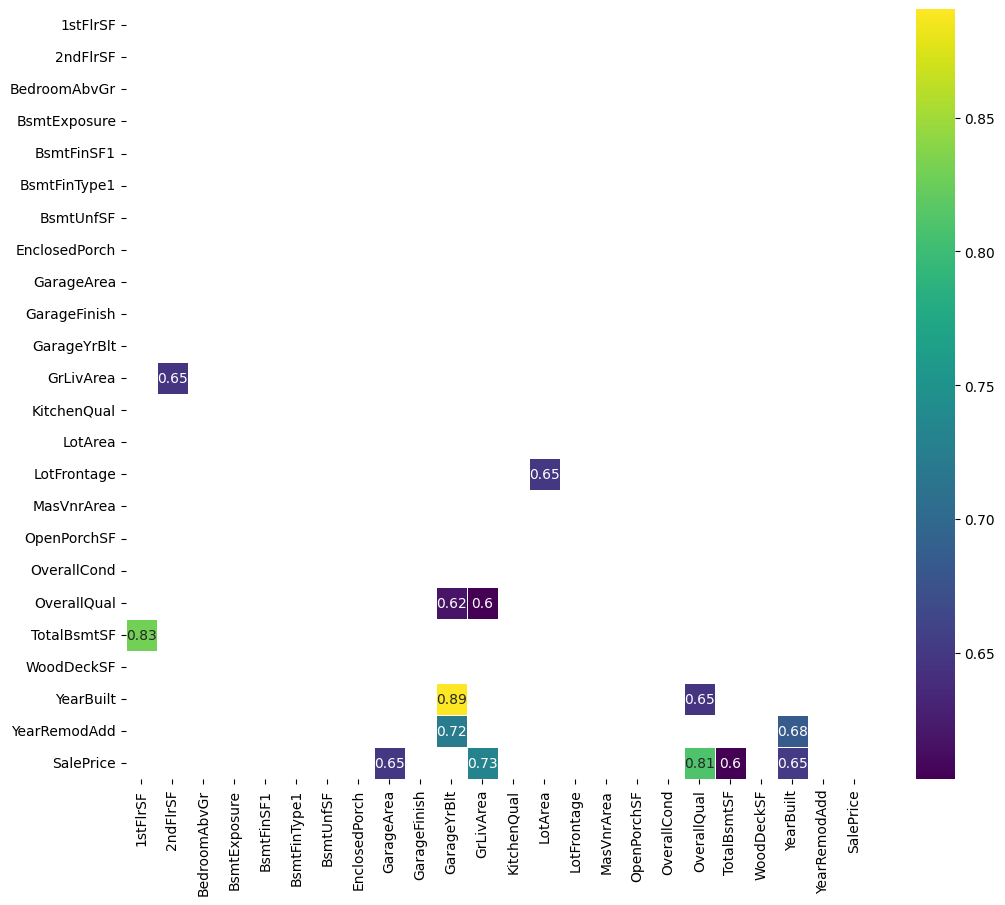



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



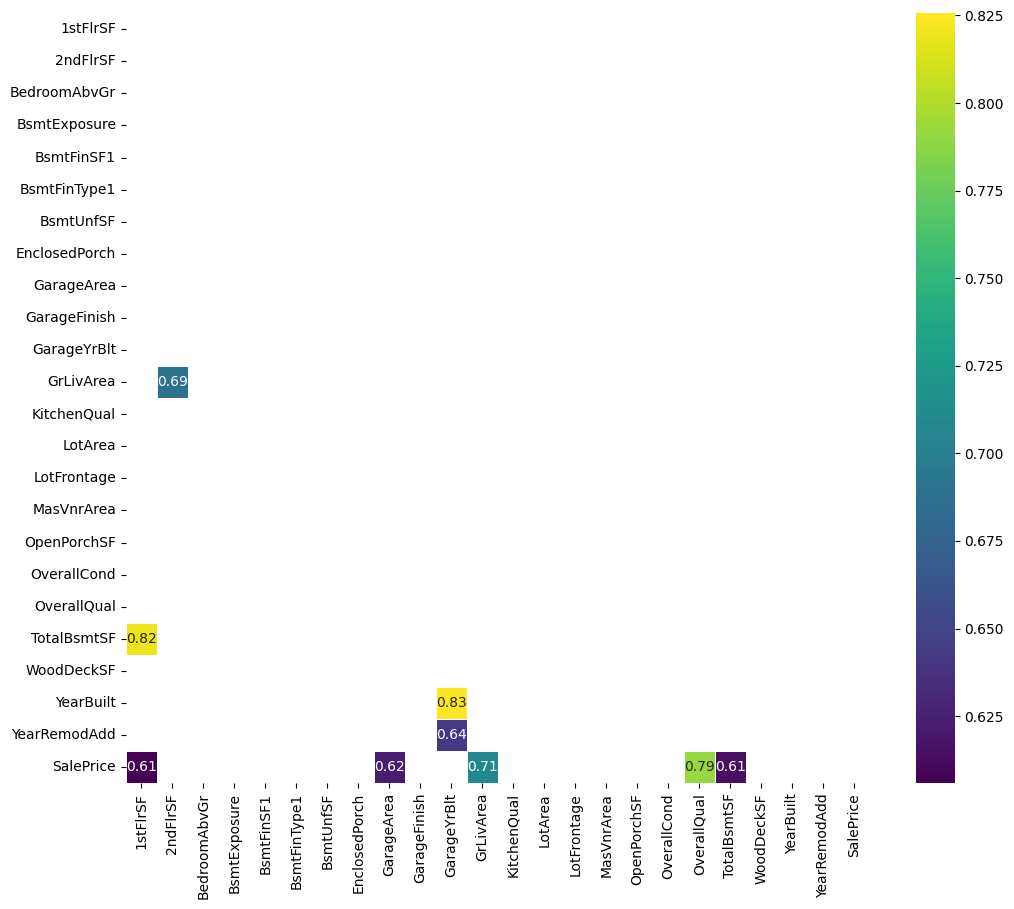

In [11]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman,
                  CorrThreshold = 0.6, PPS_Threshold = 0.2,
                  figsize=(12,10), font_annot=10)

---

# Dataset Analysis

### Data Exploration

* The data profiling report shows that there are fields that contain many zero values, beyond this there is a number of variables that do not contain data. ie. contain null values.
  * It would be necessary to examine if data would need to be filled in or in some case it is viable to drop the feature altogether.
  * A correlation study will follow where we can compare the before and after results to establish whether this exercise makes a difference to predicting sale price.

### Correlation and PPS Analysis
* Note the results show a number of variables to be moderate to strong predictors for other variables.
* However, there is a stronger interest in variables that are predictors of Sale Price.
  * From the results of both the correlation and PPS studies, We can notice that the strongest predictor of Sale Price (SalePrice) is clearly Overall Quality (OverallQual) of a property unit.
  * Overall from the correlation study we can find 6 features that are positively and strongly correlated to SalePrice, namely and them being:
    * 1stFlrSF, GarageArea, GrLivArea, OverallQual, TotalBsmtSF, YearBuilt

---

 `DataCleaningEffect()` taken from `ML Feature Engine Unit 9: Custom Functions`
* Function objective: assess the effect of cleaning the data, when
  * imput mean, median or arbitrary number is a numerical variable
  * replace with 'Missing' or most frequent a categorical variable
* Parameters: `df_original`: data not cleaned, `df_cleaned`: cleaned data, `variables_applied_with_method`: variables where you applied a given method

  * It is understandable if, at first, you don't understand all code from the function below. The point is to make sense of the pseudo-code and understand the function parameters.

In [12]:
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):

  flag_count=1 # Indicate plot number
  
  # distinguish between numerical and categorical variables
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # scan over variables, 
    # first on variables that you applied the method
    # if the variable is numerical plot a histogram, if categorical plot a barplot
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  

    for var in set_of_variables:
      if var in categorical_variables:  # it is categorical variable: barplot
        
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        dfAux = pd.concat([df1, df2], axis=0)
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # it is numerical variable: histogram

        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend() 

      plt.show()
      flag_count+= 1

---

# Data Cleaning
Check Missing Data Levels
* Custom function to show missing data levels in a dataframe, it shows the aboslute levels, relative levels and data type.

In [13]:
def EvaluateMissingData(df):
  missing_data_absolute = df.isnull().sum()
  missing_data_percentage = round(missing_data_absolute/len(df)*100 , 2)
  df_missing_data = (pd.DataFrame(
                          data= {"RowsWithMissingData": missing_data_absolute,
                                 "PercentageOfDataset": missing_data_percentage,
                                 "DataType":df.dtypes}
                                  )
                    .sort_values(by=['PercentageOfDataset'],ascending=False)
                    .query("PercentageOfDataset > 0")
                    )

  return df_missing_data

In [14]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


---

# Create a Clean Data Set

Data cleaning steps taken:

* Explore variables listed with missing data.
* Aim to Drop EnclosedPorch and WoodDeckSF - as they consists of more than 80% null values.
* Other fields may possibly be imputed with valid value or median score.

Note:
 The 6 features shown above that clearly and strongly correlate to influencing SalePrice, are not listed among the variables that contain null values.
   * 1stFlrSF, GarageArea, GrLivArea, OverallQual, TotalBsmtSF, YearBuilt

---

Create a copy of the house price records dataframe.

In [15]:
df_clean = df.copy()
print(df_clean.shape)

(1460, 24)


---

# Dataset split into Train and Test sets

In [16]:
from sklearn.model_selection import train_test_split
train_set, test_set, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"train_set shape: {train_set.shape} \ntest_set shape: {test_set.shape}")

train_set shape: (1168, 24) 
test_set shape: (292, 24)


Evaluate train_set missing values.

In [17]:
df_missing_data = EvaluateMissingData(train_set)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 7 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1056,90.41,float64
WoodDeckSF,1034,88.53,float64
LotFrontage,212,18.15,float64
BedroomAbvGr,80,6.85,float64
2ndFlrSF,60,5.14,float64
GarageYrBlt,58,4.97,float64
MasVnrArea,6,0.51,float64


---

# Individual Variable Analysis

Possible variables to consider excluding.

* Inspect `WoodDeckSF` and `EnclosedPorch` variables

In [18]:
df_wooddecksf = train_set.loc[train_set['WoodDeckSF'].notnull()]
df_wooddecksf[['WoodDeckSF', 'SalePrice']]

,WoodDeckSF,SalePrice
40,0.0,160000
703,344.0,140000
1331,0.0,132500
546,0.0,210000
638,328.0,85000
...,...,...
1419,0.0,223000
802,36.0,189000
544,100.0,179665
697,0.0,123500


In [19]:
df_wooddecksf['WoodDeckSF'].value_counts().sort_index(ascending=False).head(10)

736.0    1
550.0    1
466.0    1
431.0    1
416.0    1
382.0    1
364.0    1
356.0    1
355.0    1
351.0    1
Name: WoodDeckSF, dtype: int64

---

#### EnclosedPorch - Enclosed porch area in square feet
Exploring the missing data we can see that the variable contains more than 90% null values. Therefore, It is determined that the variable will add no value to the sale price analysis. In the inherited dataset the value for this variable is 0 for all 4 properties, meaning the porch has not been enclosed. In addition, the `Correlation and PPS Analysis` shows that this field has no predictive power over the sale price.

#### WoodDeckSF - Wood deck area in square feet
This variable is represented by approximately 89% null values. In the inherited dataset this field contains valid values, however, due to the limitation on comparative data in the train set, this variable may add no value at all. Furthermore, doing a value count shows the data contains diverse sizes and an inadequate or no amount of uniqueness , and little to no exact matches to the inherited house dataset. In addition, the `Correlation and PPS Analysis` shows that this field has no predictive power over the sales price.

#### Conclusion
Considering the above it is decided to drop both `EnclosedPorch` and `WoodDeckSF` using `feature_engine's DropFeatures` method.

In [20]:
from feature_engine.selection import DropFeatures
variables = ['EnclosedPorch', 'WoodDeckSF']
imputer = DropFeatures(features_to_drop=variables)
imputer.fit(train_set)
train_set, test_set = imputer.transform(train_set), imputer.transform(test_set)
train_set.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
618,1828,0.0,NaN,0,48,7,1774,774,3,2007.0,1828,2,11694,90.0,452.0,108,5,9,1822,2007,2007,314813
870,894,0.0,2.0,3,0,6,894,308,4,1962.0,894,3,6600,60.0,0.0,0,5,5,894,1962,1962,109500
92,964,0.0,2.0,3,713,0,163,432,3,1921.0,964,3,13360,80.0,0.0,0,7,5,876,1921,2006,163500
817,1689,0.0,3.0,3,1218,2,350,857,2,2002.0,1689,2,13265,NaN,148.0,59,5,8,1568,2002,2002,271000
302,1541,0.0,3.0,3,0,6,1541,843,2,2001.0,1541,2,13704,118.0,150.0,81,5,7,1541,2001,2002,205000


We should also drop the features from the inherited houses dataset.

In [21]:
df_clean = imputer.transform(df_clean)

---

In [22]:
null_variables = train_set.columns[train_set.isnull().any()].tolist()

* Inspect `LotFrontage` and `MasVnrArea` variables

In [23]:
train_set['LotFrontage'].value_counts().sort_index(ascending=False).head(10)

313.0    1
182.0    1
174.0    1
168.0    1
153.0    1
150.0    1
149.0    1
144.0    1
141.0    1
140.0    1
Name: LotFrontage, dtype: int64

In [24]:
train_set['MasVnrArea'].value_counts().sort_index(ascending=False).head(10)

1600.0    1
1378.0    1
1170.0    1
1129.0    1
1115.0    1
1047.0    1
975.0     1
894.0     1
870.0     1
860.0     1
Name: MasVnrArea, dtype: int64

* The PPS score on LotFrontage and MasVnrArea shows these fields have no predictive power.
* The correlation study shows they have a moderate correlation to the SalePrice
* On inspecting the dataset, for these variables, it is noted that in relation to other variables there is no way of identifying or deriving possible valid values for imputing on null variables

#### Conclusion

Use `MeanMedianImputer` to impute a `Median` value into the null variables

In [25]:
from feature_engine.imputation import MeanMedianImputer
variables = ['LotFrontage', 'MasVnrArea']
imputer = MeanMedianImputer(imputation_method='median', variables=variables)
imputer.fit(train_set)
train_set, test_set = imputer.transform(train_set), imputer.transform(test_set)

In [26]:
df_clean = imputer.transform(df_clean)

In [27]:
EvaluateMissingData(train_set)

,RowsWithMissingData,PercentageOfDataset,DataType
BedroomAbvGr,80,6.85,float64
2ndFlrSF,60,5.14,float64
GarageYrBlt,58,4.97,float64


* Missing data evaluation shows that `EnclosedPorch`, `WoodDeckSF`, `LotFrontage` and `MasVnrArea` no longer appear on the list.

---

#### 2ndFlrSF - Second floor square feet

* Inspect `2ndFlrSF` variable

In [28]:
train_set['2ndFlrSF'].value_counts().sort_index()

0.0       626
110.0       1
167.0       1
192.0       1
208.0       1
         ... 
1540.0      1
1611.0      1
1796.0      1
1818.0      1
1872.0      1
Name: 2ndFlrSF, Length: 345, dtype: int64

* `60` variables of `1168` contain null values. When studying the data, it appears that if there is no second floor the value would be set to `0`. More than 50% of values for this variable are 0. Therefore one may deduce imputing the null values with 0 would add value.
* We prepare the pipeline to use `ArbitraryNumberImputer` to impute `0` into the null variables

---

#### BedroomAbvGr - Bedrooms above grade (not including basement bedrooms)

* Inspect `BedroomAbvGr` variable

In [29]:
train_set['BedroomAbvGr'].value_counts().sort_index()

0.0      4
1.0     32
2.0    266
3.0    599
4.0    166
5.0     16
6.0      4
8.0      1
Name: BedroomAbvGr, dtype: int64

* `80` variables of `1168` contain null values. A value count shows that only 4 records have a `0` for this variable. All 4 inherited properties contain values above zero. Imputing the null values with 0 may have no effect on the sales price analysis but I deduce that `0` grading is equivalent to `null` grading.
* Prepare the pipeline to use `ArbitraryNumberImputer` to impute `0` into the null variables

---

In [30]:
pipeline = Pipeline([
      ( '2ndFlrSF',  ArbitraryNumberImputer(arbitrary_number=0,
                                                variables=['2ndFlrSF', 'BedroomAbvGr']) )
])
pipeline

Pipeline(steps=[('2ndFlrSF',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF',
                                                   'BedroomAbvGr']))])

In [31]:
pipeline.fit(train_set)
train_set, test_set = pipeline.transform(train_set), pipeline.transform(test_set)

In [32]:
df_clean = pipeline.transform(df_clean)

In [33]:
EvaluateMissingData(train_set)

,RowsWithMissingData,PercentageOfDataset,DataType
GarageYrBlt,58,4.97,float64


* Missing data evaluation shows that `2ndFlrSF` and `BedroomAbvGr` no longer appear on the list.

---

#### BsmtFinType1 - Rating of basement finished area

* Inspect `BsmtFinType1` variable

In [34]:
train_set['BsmtFinType1'].value_counts().sort_index()

0    159
1    114
2    303
3     52
4     25
5    100
6    326
7     89
Name: BsmtFinType1, dtype: int64

* Inspect `BsmtExposure` variable

In [35]:
train_set['BsmtExposure'].value_counts().sort_index()

0    174
1    106
2     92
3    768
4     28
Name: BsmtExposure, dtype: int64

In [36]:
train_set[train_set['BsmtFinType1'].isna()].query('BsmtExposure=="None"').sort_values(by=['BsmtExposure'])

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice


* `89` variables of `1168` contain null values. There are only `25` properties with no basement.
* `BsmtExposure` however contains no null variables and on comparing the two fields I established that there are `3` rows that are set to `None`, meaning that they have no basement, where `BsmtFinType1` is null. For these `3` rows the `BsmtFinType1` variable may be imputed with `None`.

In [37]:
query_condition = (train_set.BsmtExposure == 'None') & (train_set['BsmtFinType1'].isnull())
train_set['BsmtFinType1'] = np.where(query_condition, 'None', train_set['BsmtFinType1'])

In [38]:
query_condition = (test_set.BsmtExposure == 'None') & (test_set['BsmtFinType1'].isnull())
test_set['BsmtFinType1'] = np.where(query_condition, 'None', test_set['BsmtFinType1'])

In [39]:
query_condition = (df_clean.BsmtExposure == 'None') & (df_clean['BsmtFinType1'].isnull())
df_clean['BsmtFinType1'] = np.where(query_condition, 'None', df_clean['BsmtFinType1'])

In [40]:
train_set[train_set['BsmtFinType1'].isna()].query('BsmtExposure=="None"').sort_values(by=['BsmtExposure'])

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice


* The `3` rows have been imputed with `None` and hence no longer appear.

In [41]:
train_set['BsmtFinType1'].isna().sum()

0

* We can still view `86 BsmtFinType1` containing null values.

---

* Inspect `BsmtFinSF1` variable. Type 1 finished square feet.

In [42]:
df_temp = train_set[train_set['BsmtFinType1'].isna()].query('BsmtFinSF1==0').sort_values(by=['BsmtFinSF1'])
print(df_temp.shape)
df_temp

(0, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice


* We can now focus on `BsmtFinSF1` which contains no null variables. We search for `BsmtFinType1` with nulls and `BsmtFinSF1` with value `0`, meaning `0` finished square feet, which means incomplete. We are able to see that there are 27 records. Therefore, we can impute these records with `Unf` which means unfinished for `BsmtFinType1` variable.

In [43]:
query_condition = (train_set.BsmtFinSF1 == 0) & (train_set['BsmtFinType1'].isnull())
train_set['BsmtFinType1'] = np.where(query_condition, 'Unf', train_set['BsmtFinType1'])

In [44]:
query_condition = (test_set.BsmtFinSF1 == 0) & (test_set['BsmtFinType1'].isnull())
test_set['BsmtFinType1'] = np.where(query_condition, 'Unf', test_set['BsmtFinType1'])

In [45]:
query_condition = (df_clean.BsmtFinSF1 == 0) & (df_clean['BsmtFinType1'].isnull())
df_clean['BsmtFinType1'] = np.where(query_condition, 'Unf', df_clean['BsmtFinType1'])

In [46]:
train_set[train_set['BsmtFinType1'].isna()].query('BsmtFinSF1==0').sort_values(by=['BsmtFinSF1']).shape

(0, 22)

* `27` rows have been inputed with `Unf` and hence no longer appear for view.

In [47]:
train_set['BsmtFinType1'].isna().sum()

0

* There are still `59 BsmtFinType1` containing nulls. These remaing null variables will be imputed with `Unk` meaning `Unknown`

In [48]:
imputer = CategoricalImputer(imputation_method='missing',fill_value='Unk',
                             variables='BsmtFinType1')

imputer.fit(train_set)
train_set, test_set, df_clean = imputer.transform(train_set), imputer.transform(test_set), imputer.transform(df_clean)

In [49]:
train_set['BsmtFinType1'].isna().sum()

0

There are no null values in `BsmtFinType1`

---

* Inspect `GarageFinish` variable. Interior finish of the garage.

In [50]:
train_set['GarageFinish'].isna().sum()

0

* There are `131` null variables for `GarageFinish`.

In [51]:
train_set['GarageFinish'].value_counts().sort_index()

0    254
1     53
2    293
3    437
4    131
Name: GarageFinish, dtype: int64

In [52]:
train_set.loc[train_set.GarageFinish=="None",'GarageArea'].value_counts()

Series([], Name: GarageArea, dtype: int64)

* Note above, where `GarageFinish=="None"`, meaning there is no garage, `GarageArea` is found to be `0`.

In [53]:
train_set.loc[train_set.GarageFinish.isnull(),'GarageArea'].value_counts()

Series([], Name: GarageArea, dtype: int64)

* Therefore, where `GarageFinish` is null we can see if `GarageArea` is `0` and if so we can impute `None` on `GarageFinish`.
* Based on the above query, only `5` rows should be affected.
* For the remaining records we will assume that the garages are unfinished and hence impute `Unf` on `GarageFinish`.

In [54]:
query_condition = (train_set.GarageArea == 0) & (train_set['GarageFinish'].isnull())
train_set['GarageFinish'] = np.where(query_condition, 'None', train_set['GarageFinish'])

In [55]:
query_condition = (test_set.GarageArea == 0) & (test_set['GarageFinish'].isnull())
test_set['GarageFinish'] = np.where(query_condition, 'None', test_set['GarageFinish'])

In [56]:
query_condition = (df_clean.GarageArea == 0) & (df_clean['GarageFinish'].isnull())
df_clean['GarageFinish'] = np.where(query_condition, 'None', df_clean['GarageFinish'])

In [57]:
train_set['GarageFinish'].isna().sum()

0

In [58]:
pipeline = Pipeline([
      ( 'categorical_imputer', CategoricalImputer(imputation_method='missing',
                                                  fill_value='Unf',
                                                  variables=['GarageFinish']) )
])
pipeline

Pipeline(steps=[('categorical_imputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish']))])

In [59]:
pipeline.fit(train_set)

train_set, test_set = pipeline.transform(train_set), pipeline.transform(test_set)

In [60]:
df_clean = pipeline.transform(df_clean)

In [61]:
train_set['GarageFinish'].isna().sum()

0

There are no null values in `GarageFinish`

---

* Inspect `GarageYrBlt` variable. Year garage was built.

In [62]:
train_set['GarageYrBlt'].isna().sum()

58

* Get a row count of where `GarageYrBlt` is null, and return the value of `GarageFinish`.

In [63]:
train_set.loc[train_set.GarageYrBlt.isnull(),'GarageFinish'].value_counts()

1    53
4     5
Name: GarageFinish, dtype: int64

In [64]:
train_set[train_set.GarageFinish=='None']

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice


* Note there are `58` null records for the `GarageYrBlt` and where this variable is null `GarageFinish` is `None`, meaning there is no garage.
* Prepare a pipeline to use `ArbitraryNumberImputer` to impute `0` into the null variables

In [65]:
pipeline = Pipeline([
      ( 'GarageYrBlt',  ArbitraryNumberImputer(arbitrary_number=0,
                                                variables='GarageYrBlt') )
])
pipeline

pipeline.fit(train_set)
train_set, test_set = pipeline.transform(train_set), pipeline.transform(test_set)

In [66]:
df_clean = pipeline.transform(df_clean)

---

Show missing data evaluation.

In [67]:
EvaluateMissingData(train_set)

,RowsWithMissingData,PercentageOfDataset,DataType


In [68]:
EvaluateMissingData(df_clean)

,RowsWithMissingData,PercentageOfDataset,DataType


* We do not have any variables missing data.

---

## Before and After comparison

To Assess the effect on the variable distribution
* All function plots in the same Axes are found in the distribution before and after applying the method. This helps to give insights into how different your variable would look after cleaning it.
* We notice the "peak" in the variable distribution after median imputation.


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['2ndFlrSF', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea'] 




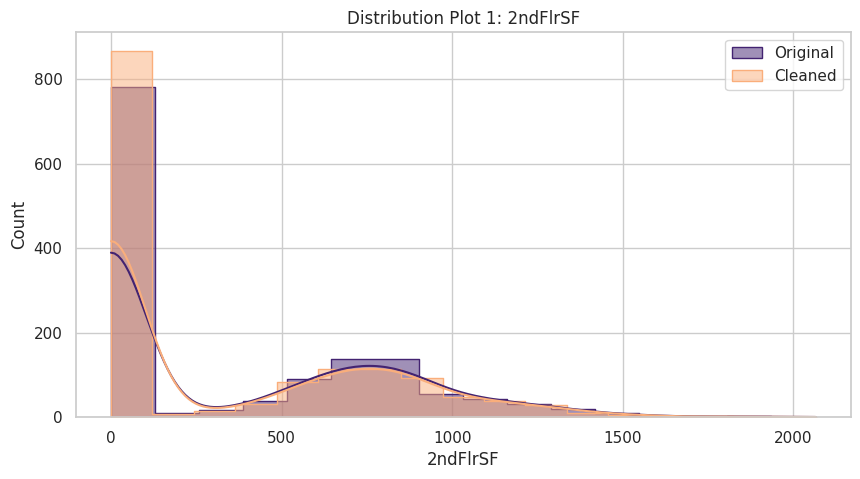

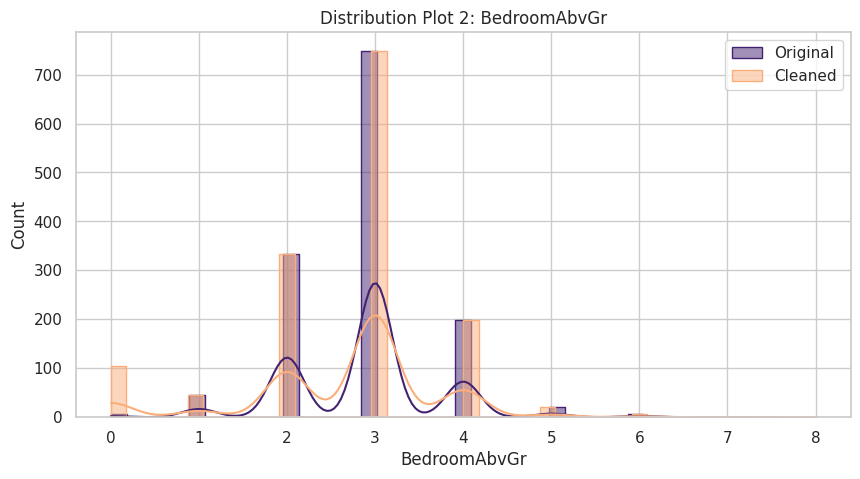

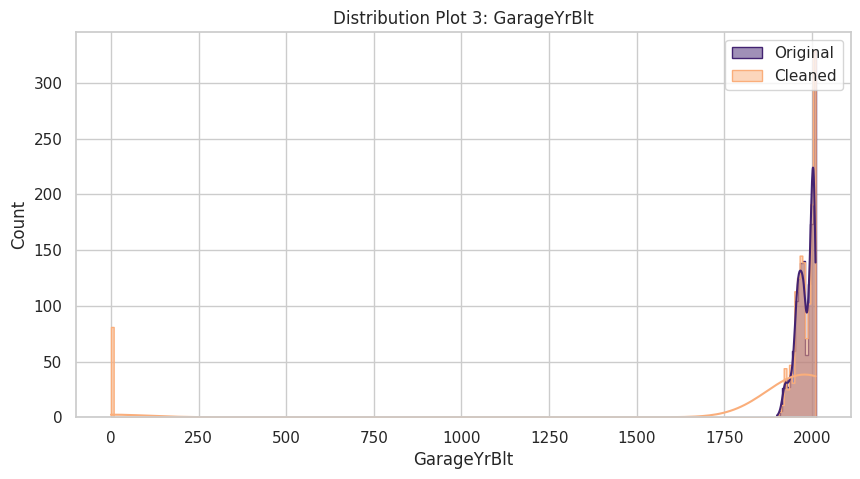

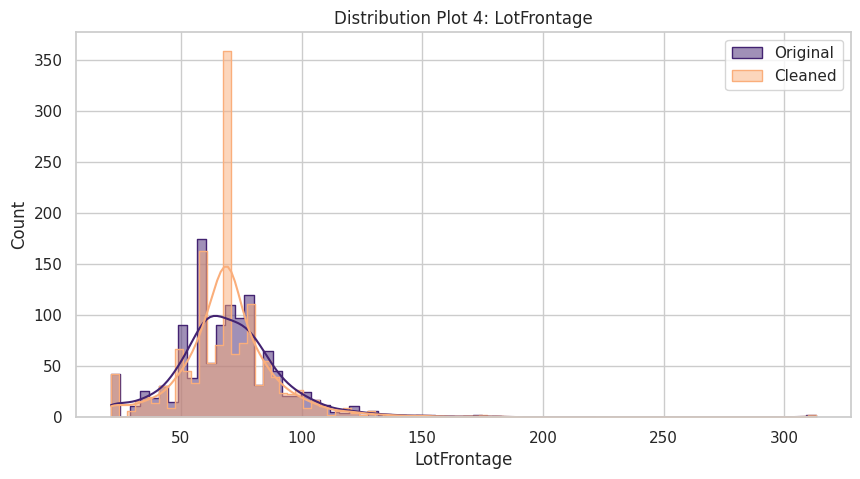

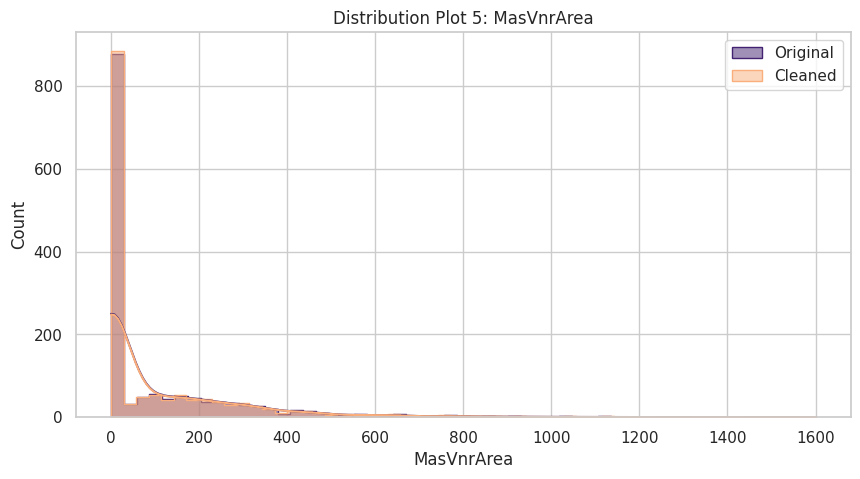

In [69]:
DataCleaningEffect(df_original=df,
                   df_cleaned=df_clean,
                   variables_applied_with_method=null_variables)

---

## Datatype changes - `Float` to `Integer`

On exploring the data within the house dataset, we can see that there are no float values in the float columns so we will change these to integers.

In [70]:
print(df_clean.shape)

(1460, 22)


In [71]:
df_clean.select_dtypes('float').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   2ndFlrSF      1460 non-null   float64
 1   BedroomAbvGr  1460 non-null   float64
 2   GarageYrBlt   1460 non-null   float64
 3   LotFrontage   1460 non-null   float64
 4   MasVnrArea    1460 non-null   float64
dtypes: float64(5)
memory usage: 57.2 KB


In [72]:
for col in df_clean.select_dtypes('float').columns:
    df_clean[col] = df_clean[col].astype('int64')

In [73]:
df_clean.select_dtypes('float').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Empty DataFrame


On exploring the data in the inherited houses dataset, we can see that there are no float values in the float columns so we will change these to integers.

In [74]:
for col in df_inherited.select_dtypes('float').columns:
    df_inherited[col] = df_inherited[col].astype('int64')

In [75]:
df_inherited.select_dtypes('float').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Empty DataFrame


In [76]:
df_inherited.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   1stFlrSF       4 non-null      int64 
 1   2ndFlrSF       4 non-null      int64 
 2   BedroomAbvGr   4 non-null      int64 
 3   BsmtExposure   4 non-null      object
 4   BsmtFinSF1     4 non-null      int64 
 5   BsmtFinType1   4 non-null      object
 6   BsmtUnfSF      4 non-null      int64 
 7   EnclosedPorch  4 non-null      int64 
 8   GarageArea     4 non-null      int64 
 9   GarageFinish   4 non-null      object
 10  GarageYrBlt    4 non-null      int64 
 11  GrLivArea      4 non-null      int64 
 12  KitchenQual    4 non-null      object
 13  LotArea        4 non-null      int64 
 14  LotFrontage    4 non-null      int64 
 15  MasVnrArea     4 non-null      int64 
 16  OpenPorchSF    4 non-null      int64 
 17  OverallCond    4 non-null      int64 
 18  OverallQual    4 non-null      int

---

Change float columns to integers for both train and test sets.

In [77]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 618 to 684
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   1stFlrSF      1168 non-null   int64  
 1   2ndFlrSF      1168 non-null   float64
 2   BedroomAbvGr  1168 non-null   float64
 3   BsmtExposure  1168 non-null   int64  
 4   BsmtFinSF1    1168 non-null   int64  
 5   BsmtFinType1  1168 non-null   object 
 6   BsmtUnfSF     1168 non-null   int64  
 7   GarageArea    1168 non-null   int64  
 8   GarageFinish  1168 non-null   object 
 9   GarageYrBlt   1168 non-null   float64
 10  GrLivArea     1168 non-null   int64  
 11  KitchenQual   1168 non-null   int64  
 12  LotArea       1168 non-null   int64  
 13  LotFrontage   1168 non-null   float64
 14  MasVnrArea    1168 non-null   float64
 15  OpenPorchSF   1168 non-null   int64  
 16  OverallCond   1168 non-null   int64  
 17  OverallQual   1168 non-null   int64  
 18  TotalBsmtSF   1168 non-null

In [78]:
for col in train_set.select_dtypes('float').columns:
    train_set[col] = train_set[col].astype('int64')

In [79]:
for col in test_set.select_dtypes('float').columns:
    test_set[col] = test_set[col].astype('int64')

---

## Save Train and Test sets to csv

Make a clean folder.

In [80]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned') # create outputs/datasets/collection folder
except Exception as e:
  print(e)

Our expected outputs would be:

* output the clean datasets to csv files into the outputs/datasets folder
* outputs/datasets/cleaned/train_set.csv
* outputs/datasets/cleaned/test_set.csv
* outputs/datasets/cleaned/clean_house_price_records.csv

In [81]:
train_set.to_csv("outputs/datasets/cleaned/train_set.csv", index=False)

In [82]:
test_set.to_csv("outputs/datasets/cleaned/test_set.csv", index=False)

In [83]:
df_clean.to_csv("outputs/datasets/cleaned/clean_house_price_records.csv", index=False)

In [84]:
df_inherited.to_csv("outputs/datasets/cleaned/clean_inherited_houses.csv", index=False)

---

## Conclusion and Steps to Follow

* We created a clean version of both the housing price dataset and the inherited houses datasets
* From the inherited dataset we only dropped the variables `EnclosedPorch` and `WoodDeckSF` a the showed no added value.
* The housing price dataset was also split into both Train and Test set.
* The clean datasets were saved to csv files, in the outputs/datasets/cleaned folder:
  * clean_house_price_records.csv
  * clean_inherited_houses.csv
  * train_set.csv
  * test_set.csv
* We can no undertake feature engineering.